In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

# Load all packages used
import matplotlib.pyplot as plt
import numpy as np
import mypackage

TensorFlow version is 2.1.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1 2 3] (5, 100, 100, 1) (-3.1359024, 4.5110693) (5, 100, 100, 3)


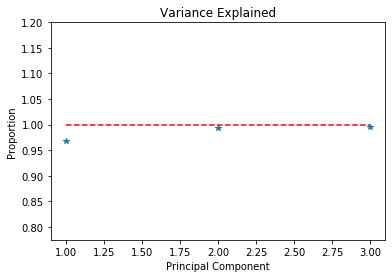

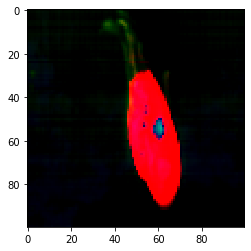

In [2]:
# Load the dataset
X, Y, info = mypackage.Dataset.load("data/tomra", only_with_contaminant=True)
X_train, X_test, Y_train, Y_test = mypackage.Dataset.train_test_split(X, Y, testRatio=0.3)

X_test, X_train = mypackage.Dataset.scale(X_test, X_train, scale='GlobalCenterting')
X_test, X_train = mypackage.Dataset.PCA(X_test, X_train, n_components=3, plot=True)

print(np.unique(Y_test), Y_test.shape, (X_test.min(), X_test.max()), X_test.shape)

# Testing UNet model

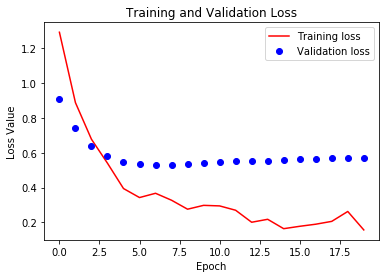

2
Predicted classes
[0 1]
Occurrences of each:
[16089   295]


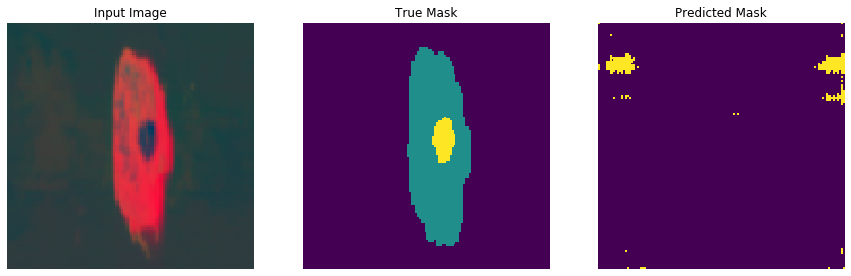

In [8]:
mypackage.standard_unet.run(X_train, Y_train-1, X_test, Y_test-1, output_chanels=3, epochs=20, steps_per_epoch=1, clear_output=True)

# Testing SVM

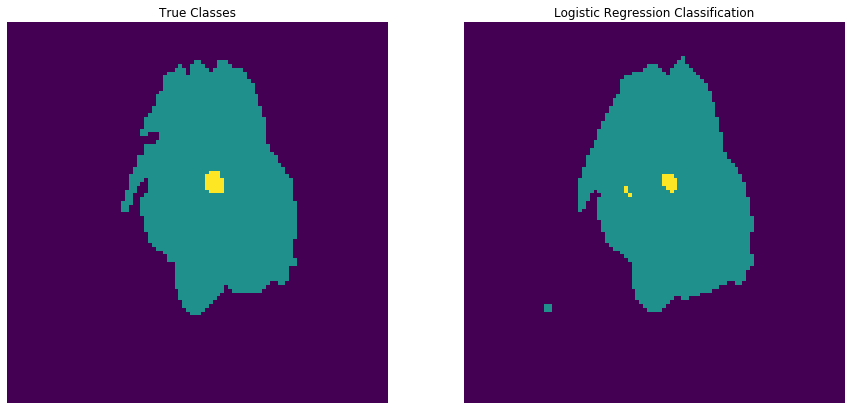

In [24]:
from sklearn import svm

train = mypackage.StackTransform(X_train, Y_train)
test = mypackage.StackTransform(X_test)

svc_classifier = svm.SVC(C=1, kernel='rbf', decision_function_shape='ovr')
svc_classifier.fit(train.X_stack(), train.Y_stack().ravel())
Y_hat = svc_classifier.predict(test.X_stack())
Y_hat = test.Unstack(Y_hat, k=1)

import matplotlib.pyplot as plt
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.title("True Classes")
plt.imshow(np.squeeze(Y_test[0]))
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("Logistic Regression Classification")
plt.imshow(np.squeeze(Y_hat[0]))
plt.axis('off');

# Testing Logistic Regression

In [ ]:
log_reg = mypackage.logistic_regression(X_train, Y_train, X_test, Y_test, C=1e5)

In [ ]:
from sklearn import preprocessing

X, Y, info, X_rest = mypackage.Dataset.load("data/tomra", only_with_contaminant=True, load_rest=True)
X_rest, X = mypackage.Dataset.scale(X_rest, X, scale='RemoveTrend')
trans = mypackage.StackTransform(X, Y)
trans_rest = mypackage.StackTransform(X_rest)

# Scaling
scaler = preprocessing.StandardScaler()
scaler.fit(trans.X_stack())
X_scaled = scaler.transform(trans.X_stack())
X_scaled = trans.Unstack(X_scaled)

log_reg = mypackage.logistic_regression(X_scaled, Y, X_rest, None, C=1e5, plot=False, metrics=False, max_iter=10000)

(10000, 208)
(10000,)
(1, 100, 100, 1)


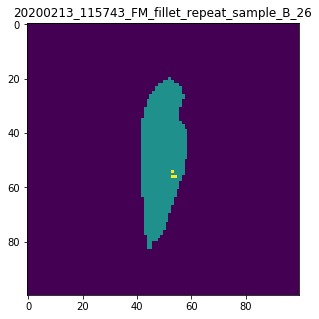

(10000, 208)
(10000,)
(1, 100, 100, 1)


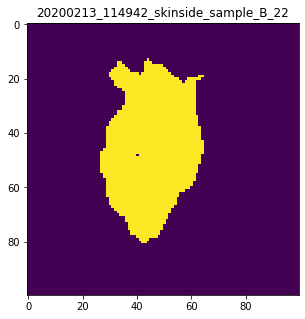

(10000, 208)
(10000,)
(1, 100, 100, 1)


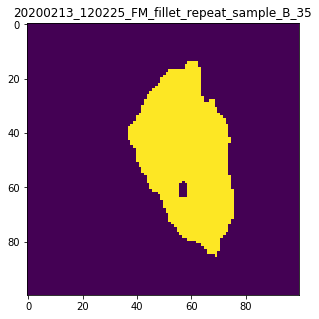

(10000, 208)
(10000,)
(1, 100, 100, 1)


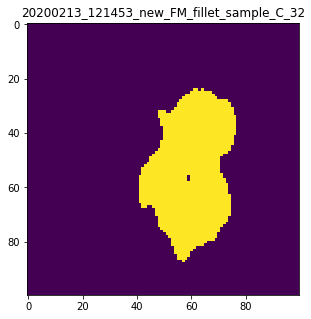

(10000, 208)
(10000,)
(1, 100, 100, 1)


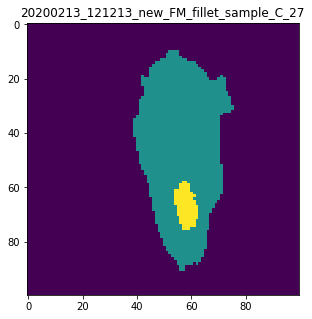

(10000, 208)
(10000,)
(1, 100, 100, 1)


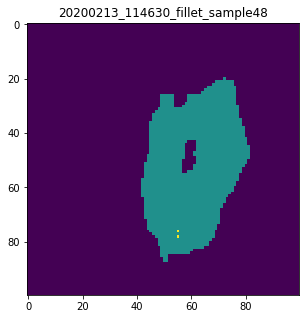

(10000, 208)
(10000,)
(1, 100, 100, 1)


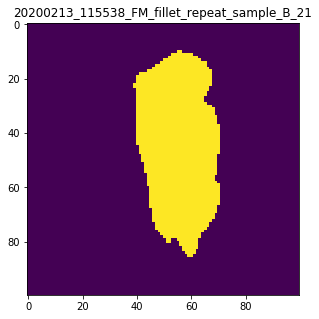

(10000, 208)
(10000,)
(1, 100, 100, 1)


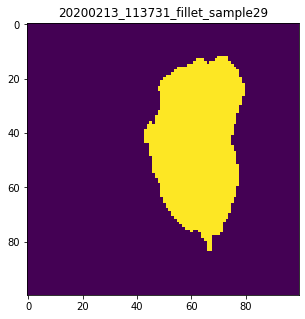

(10000, 208)
(10000,)
(1, 100, 100, 1)


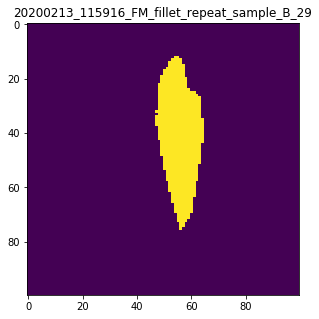

(10000, 208)
(10000,)
(1, 100, 100, 1)


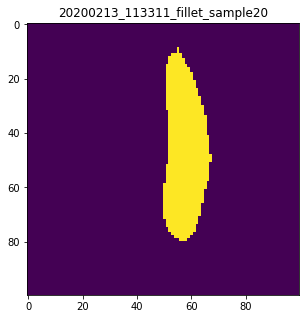

(10000, 208)
(10000,)
(1, 100, 100, 1)


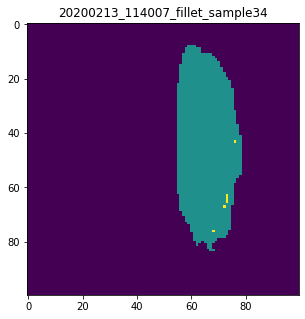

(10000, 208)
(10000,)
(1, 100, 100, 1)


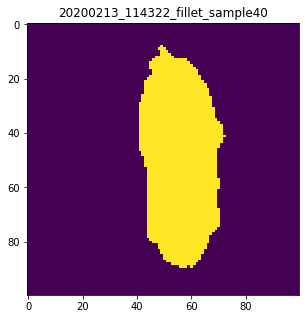

(10000, 208)
(10000,)
(1, 100, 100, 1)


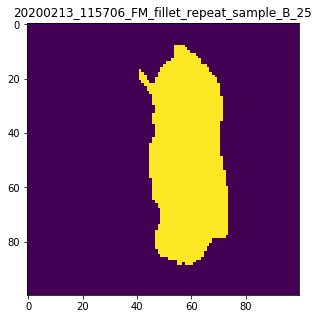

(10000, 208)
(10000,)
(1, 100, 100, 1)


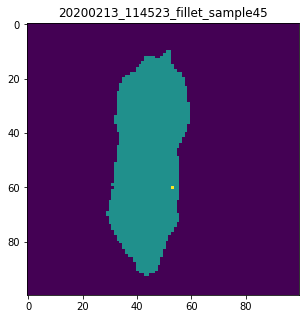

(10000, 208)
(10000,)
(1, 100, 100, 1)


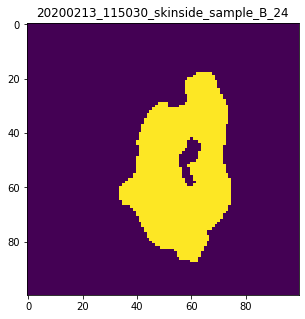

(10000, 208)
(10000,)
(1, 100, 100, 1)


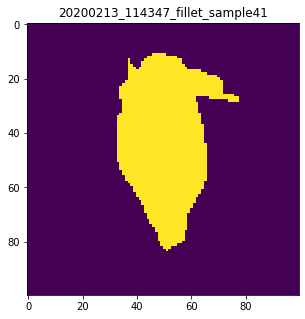

(10000, 208)
(10000,)
(1, 100, 100, 1)


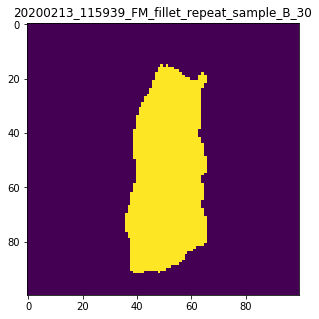

(10000, 208)
(10000,)
(1, 100, 100, 1)


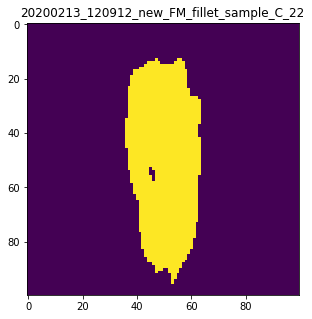

(10000, 208)
(10000,)
(1, 100, 100, 1)


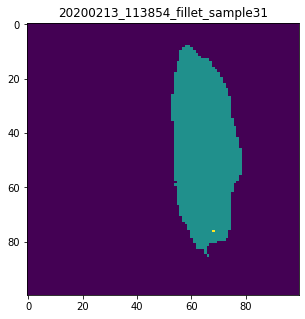

(10000, 208)
(10000,)
(1, 100, 100, 1)


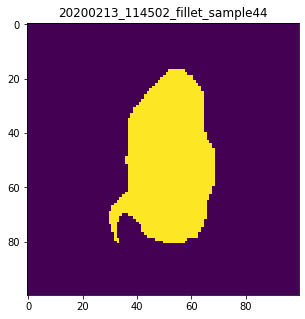

(10000, 208)
(10000,)
(1, 100, 100, 1)


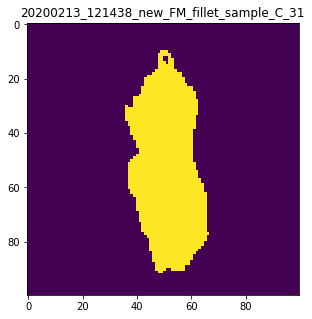

(10000, 208)
(10000,)
(1, 100, 100, 1)


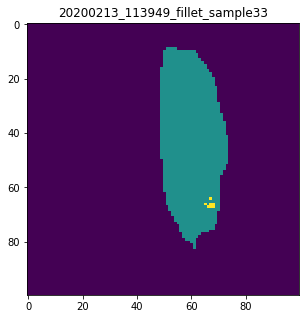

(10000, 208)
(10000,)
(1, 100, 100, 1)


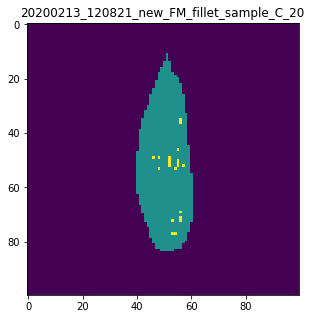

(10000, 208)
(10000,)
(1, 100, 100, 1)


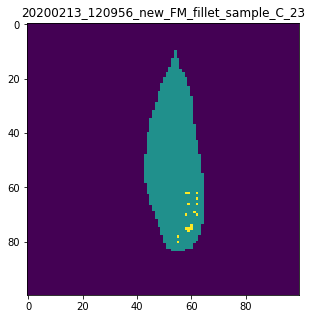

(10000, 208)
(10000,)
(1, 100, 100, 1)


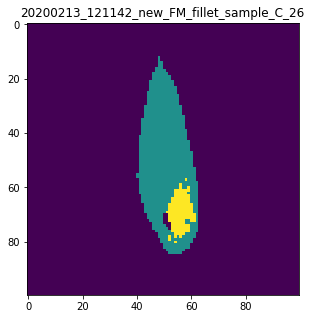

(10000, 208)
(10000,)
(1, 100, 100, 1)


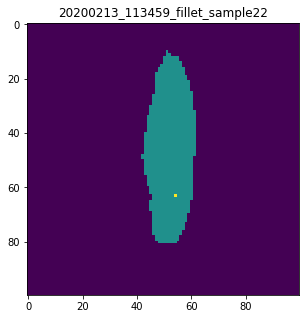

(10000, 208)
(10000,)
(1, 100, 100, 1)


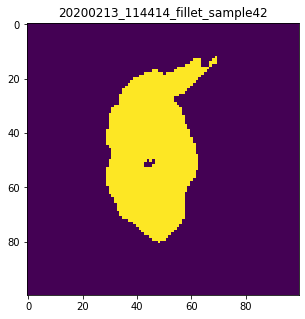

(10000, 208)
(10000,)
(1, 100, 100, 1)


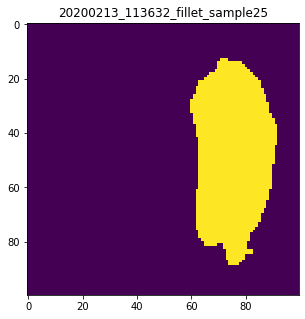

(10000, 208)
(10000,)
(1, 100, 100, 1)


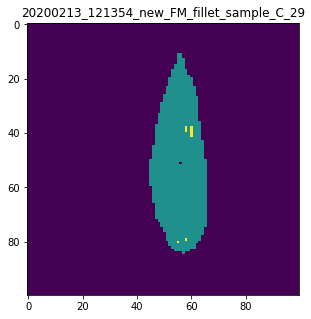

(10000, 208)
(10000,)
(1, 100, 100, 1)


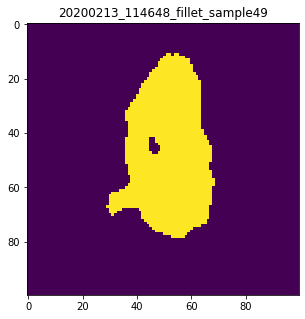

(10000, 208)
(10000,)
(1, 100, 100, 1)


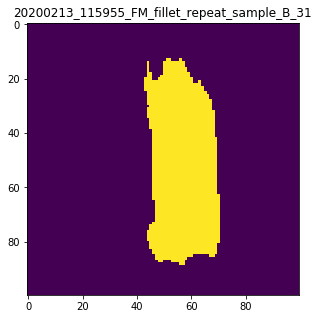

(10000, 208)
(10000,)
(1, 100, 100, 1)


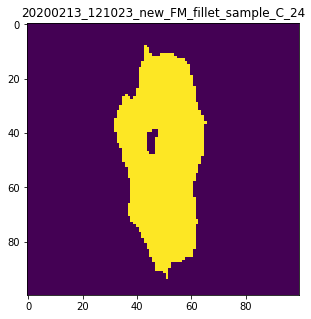

(10000, 208)
(10000,)
(1, 100, 100, 1)


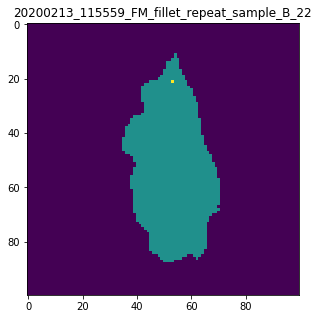

(10000, 208)
(10000,)
(1, 100, 100, 1)


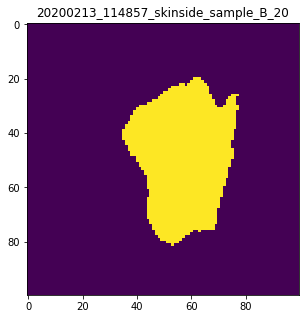

(10000, 208)
(10000,)
(1, 100, 100, 1)


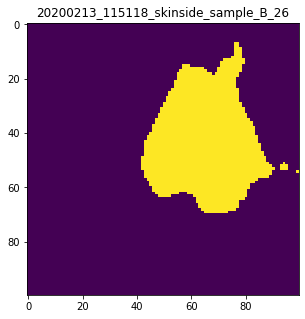

(10000, 208)
(10000,)
(1, 100, 100, 1)


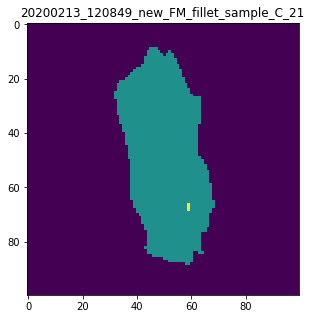

(10000, 208)
(10000,)
(1, 100, 100, 1)


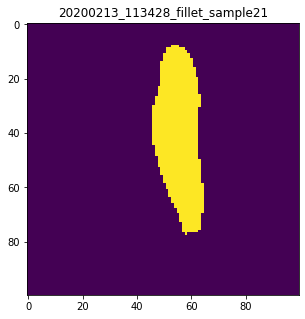

(10000, 208)
(10000,)
(1, 100, 100, 1)


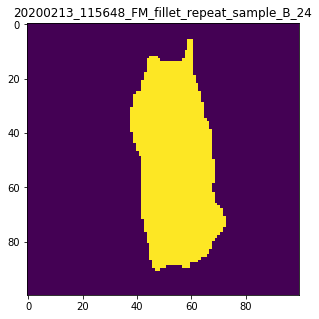

(10000, 208)
(10000,)
(1, 100, 100, 1)


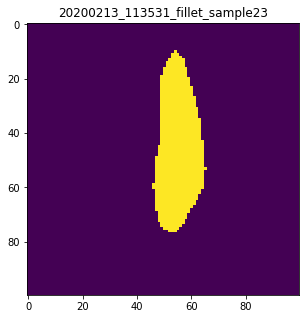

(10000, 208)
(10000,)
(1, 100, 100, 1)


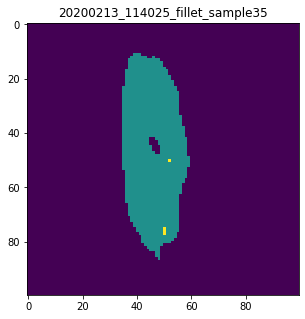

(10000, 208)
(10000,)
(1, 100, 100, 1)


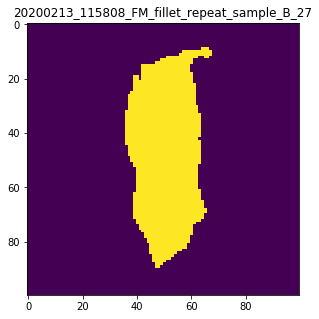

(10000, 208)
(10000,)
(1, 100, 100, 1)


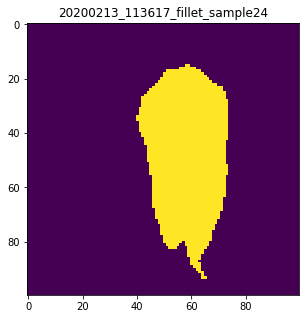

(10000, 208)
(10000,)
(1, 100, 100, 1)


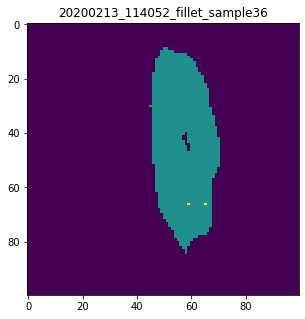

(10000, 208)
(10000,)
(1, 100, 100, 1)


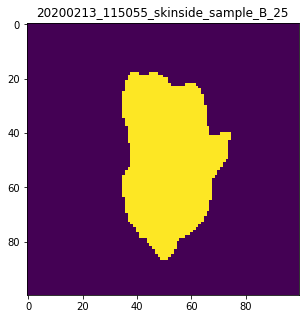

(10000, 208)
(10000,)
(1, 100, 100, 1)


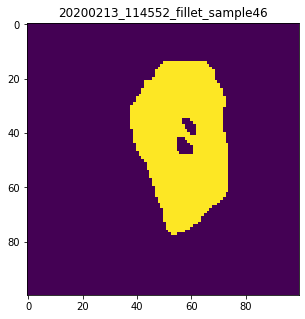

(10000, 208)
(10000,)
(1, 100, 100, 1)


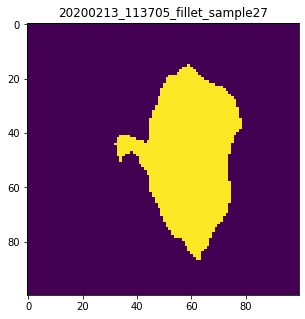

(10000, 208)
(10000,)
(1, 100, 100, 1)


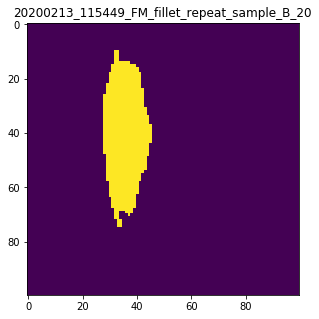

(10000, 208)
(10000,)
(1, 100, 100, 1)


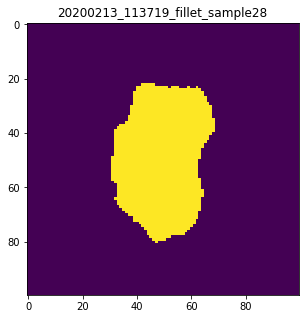

(10000, 208)
(10000,)
(1, 100, 100, 1)


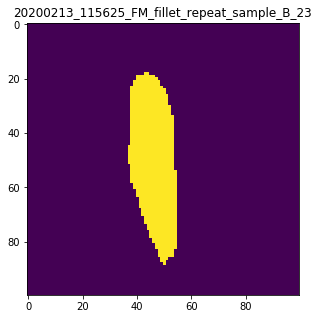

(10000, 208)
(10000,)
(1, 100, 100, 1)


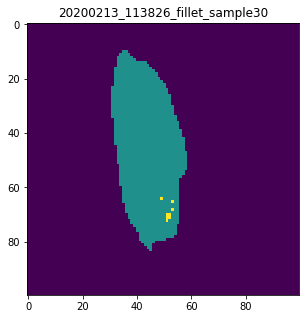

(10000, 208)
(10000,)
(1, 100, 100, 1)


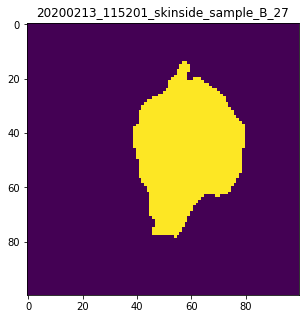

(10000, 208)
(10000,)
(1, 100, 100, 1)


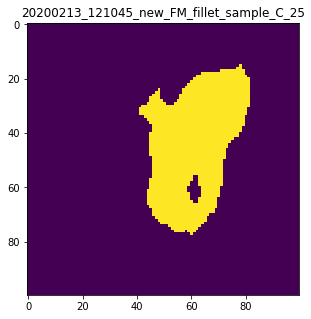

(10000, 208)
(10000,)
(1, 100, 100, 1)


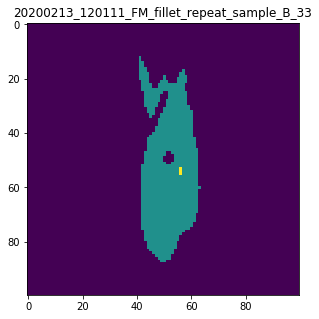

(10000, 208)
(10000,)
(1, 100, 100, 1)


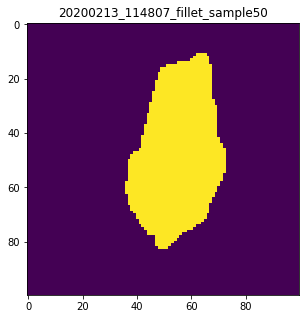

(10000, 208)
(10000,)
(1, 100, 100, 1)


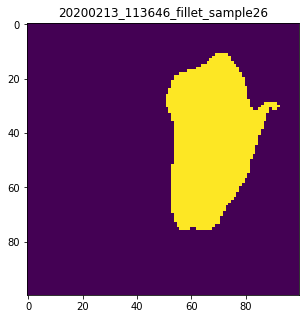

(10000, 208)
(10000,)
(1, 100, 100, 1)


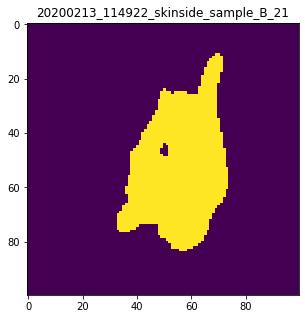

(10000, 208)
(10000,)
(1, 100, 100, 1)


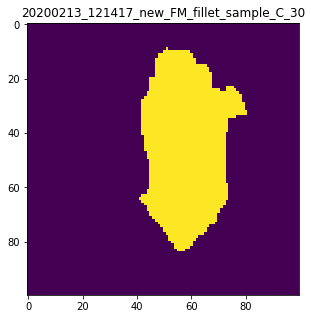

(10000, 208)
(10000,)
(1, 100, 100, 1)


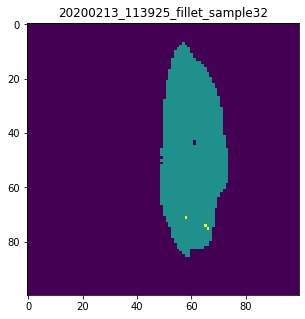

(10000, 208)
(10000,)
(1, 100, 100, 1)


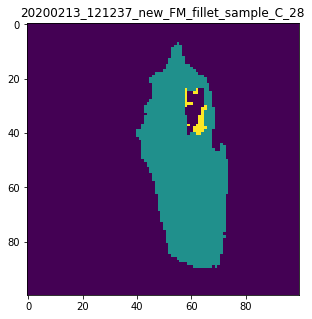

(10000, 208)
(10000,)
(1, 100, 100, 1)


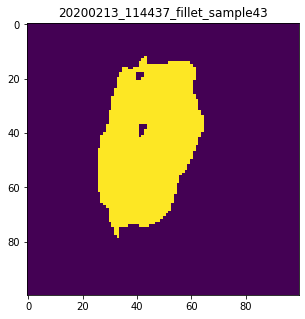

(10000, 208)
(10000,)
(1, 100, 100, 1)


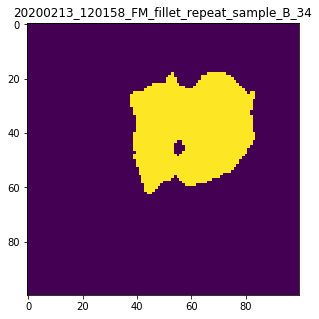

In [80]:
# Plot the classification of the rest
file_list = ['20200213_115743_FM_fillet_repeat_sample_B_26', '20200213_114942_skinside_sample_B_22', '20200213_120225_FM_fillet_repeat_sample_B_35', '20200213_121453_new_FM_fillet_sample_C_32', '20200213_121213_new_FM_fillet_sample_C_27', '20200213_114630_fillet_sample48', '20200213_115538_FM_fillet_repeat_sample_B_21', '20200213_113731_fillet_sample29', '20200213_115916_FM_fillet_repeat_sample_B_29', '20200213_113311_fillet_sample20', '20200213_114007_fillet_sample34', '20200213_114322_fillet_sample40', '20200213_115706_FM_fillet_repeat_sample_B_25', '20200213_114523_fillet_sample45', '20200213_115030_skinside_sample_B_24', '20200213_114347_fillet_sample41', '20200213_115939_FM_fillet_repeat_sample_B_30', '20200213_120912_new_FM_fillet_sample_C_22', '20200213_113854_fillet_sample31', '20200213_114502_fillet_sample44', '20200213_121438_new_FM_fillet_sample_C_31', '20200213_113949_fillet_sample33', '20200213_120821_new_FM_fillet_sample_C_20', '20200213_120956_new_FM_fillet_sample_C_23', '20200213_121142_new_FM_fillet_sample_C_26', '20200213_113459_fillet_sample22', '20200213_114414_fillet_sample42', '20200213_113632_fillet_sample25', '20200213_121354_new_FM_fillet_sample_C_29', '20200213_114648_fillet_sample49', '20200213_115955_FM_fillet_repeat_sample_B_31', '20200213_121023_new_FM_fillet_sample_C_24', '20200213_115559_FM_fillet_repeat_sample_B_22', '20200213_114857_skinside_sample_B_20', '20200213_115118_skinside_sample_B_26', '20200213_120849_new_FM_fillet_sample_C_21', '20200213_113428_fillet_sample21', '20200213_115648_FM_fillet_repeat_sample_B_24', '20200213_113531_fillet_sample23', '20200213_114025_fillet_sample35', '20200213_115808_FM_fillet_repeat_sample_B_27', '20200213_113617_fillet_sample24', '20200213_114052_fillet_sample36', '20200213_115055_skinside_sample_B_25', '20200213_114552_fillet_sample46', '20200213_113705_fillet_sample27', '20200213_115449_FM_fillet_repeat_sample_B_20', '20200213_113719_fillet_sample28', '20200213_115625_FM_fillet_repeat_sample_B_23', '20200213_113826_fillet_sample30', '20200213_115201_skinside_sample_B_27', '20200213_121045_new_FM_fillet_sample_C_25', '20200213_120111_FM_fillet_repeat_sample_B_33', '20200213_114807_fillet_sample50', '20200213_113646_fillet_sample26', '20200213_114922_skinside_sample_B_21', '20200213_121417_new_FM_fillet_sample_C_30', '20200213_113925_fillet_sample32', '20200213_121237_new_FM_fillet_sample_C_28', '20200213_114437_fillet_sample43', '20200213_120158_FM_fillet_repeat_sample_B_34']
for i, file_name in enumerate(file_list):
    rest = mypackage.StackTransform(X_rest[i:i+1])
    X_stacked = rest.X_stack()
    Y_hat_stacked = log_reg.predict(X_stacked)
    Y_hat = rest.Unstack(Y_hat_stacked, k=1)

    plt.figure(figsize=(10, 5))
    plt.title(file_name)
    plt.imshow(np.squeeze(Y_hat))
    plt.imsave(file_name+'.png', np.squeeze(Y_hat))
    plt.show()

# Test Partial Least Squares - Discriminant Analysis (PLS-DA)

# Evaluate the results
### With precision / recall or something